In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import files
unpload = files.upload()

Saving abc.csv to abc.csv


In [3]:
df = pd.read_csv('abc.csv', index_col='Date' , parse_dates = True)

In [4]:
df.head()

,Daily Confirmed
Date,
2020-01-30,1
2020-01-31,0
2020-02-01,0
2020-02-02,1
2020-02-03,1


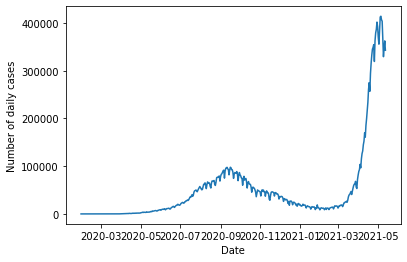

In [5]:
plt.xlabel('Date')
plt.ylabel('Number of daily cases')
plt.plot(df)

<function matplotlib.pyplot.show>

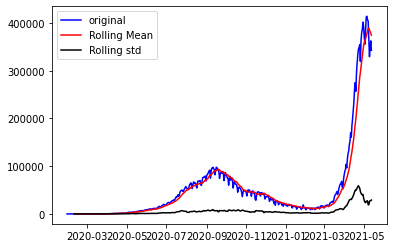

In [6]:
rolling_mean = df.rolling(window = 12).mean()
rolling_std = df.rolling(window = 12).std()

plt.plot(df,color ='blue' , label = 'original')
plt.plot(rolling_mean, color = 'red', label ='Rolling Mean')
plt.plot(rolling_std, color = 'black', label ='Rolling std')
plt.legend(loc = 'best')
plt.show


In [7]:
result = adfuller(df['Daily Confirmed'])

print("ADF stastistic :" , result[0])
print("p-value: ", result[1])
print("critical values: ")
for key,val in result[4].items():
  print(key," ", val)

ADF stastistic : -5.32466253084978
p-value:  4.8669924232872055e-06
critical values: 
1%   -3.444836032925901
5%   -2.8679272692747415
10%   -2.5701721745036776


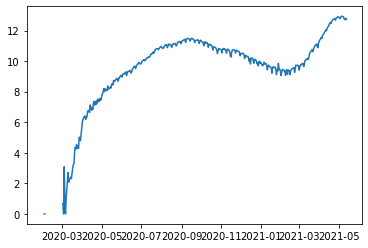

In [8]:
df_log = np.log(df)
plt.plot(df_log)

In [9]:
def get_stationarity(timeseries):

  #rolling stat
  rolling_mean = timeseries.rolling(window =12).mean()
  rolling_std = timeseries.rolling(window = 12).std()

  #rolling stat plt
  original = plt.plot(timeseries,color = 'blue' , label = 'original')
  mean = plt.plot(rolling_mean, color = 'red' , label = 'Rolling Mean')
  std = plt.plot(rolling_std, color = 'red' , label = 'Rolling std')

  plt.legend(loc = 'best')
  plt.show(block = False)

  #test
  result = adfuller(timeseries['Daily Confirmed'])
  print("ADF stastistic :" , result[0])
  print("p-value: ", result[1])
  print("critical values: ")
  for key,val in result[4].items():
    print(key," ", val)



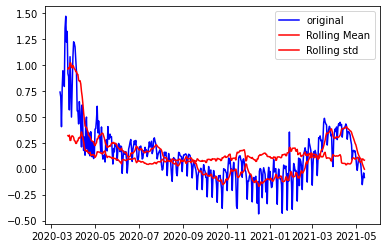

ADF stastistic : -3.6588734066806925
p-value:  0.004730265945588531
critical values: 
1%   -3.4463612216221775
5%   -2.8685980017932917
10%   -2.5705296947685605


In [10]:
rolling_mean = df_log.rolling(window = 12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace = True)

get_stationarity(df_log_minus_mean)

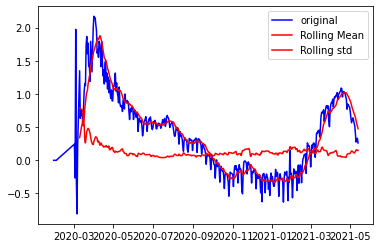

ADF stastistic : -2.404479300545092
p-value:  0.14047614842073236
critical values: 
1%   -3.445830555854264
5%   -2.8683646683004276
10%   -2.570405316262976


In [11]:
rolling_mean_exp_decay = df_log.ewm(halflife = 12 , min_periods= 0, adjust = True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna()

#df_log_exp_decay.head()
#df_log_exp_decay.
#df_log_exp_decay = df_log_exp_decay[df_log_exp_decay['Daily Confirmed'] != '-inf']
df_log_exp_decay = df_log_exp_decay[~df_log_exp_decay.isin([-np.inf]).any(1)]
df_log_exp_decay.head()
get_stationarity(df_log_exp_decay)

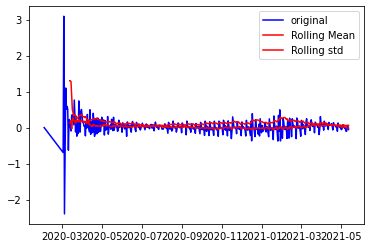

ADF stastistic : -2.408971748391802
p-value:  0.1392201942495519
critical values: 
1%   -3.44594128742536
5%   -2.868413360220551
10%   -2.570431271085555


In [12]:
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace  = True)
df_log_shift.head()
df_log_shift = df_log_shift[~df_log_shift.isin([-np.inf, np.inf]).any(1)]
get_stationarity(df_log_shift)

In [ ]:
pip install pmdarima

     |████████████████████████████████| 1.5MB 8.7MB/s 
     |████████████████████████████████| 9.5MB 27.5MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
#from pmdarima import auto_arima
#import warnings
#warnings.filterwarnings("ignore")

In [13]:
df_log = df_log[~df_log.isin([-np.inf, np.inf]).any(1)]
df_log.head()

,Daily Confirmed
Date,
2020-01-30,0.000000
2020-02-02,0.000000
2020-02-03,0.000000
2020-03-02,0.693147
2020-03-03,0.000000


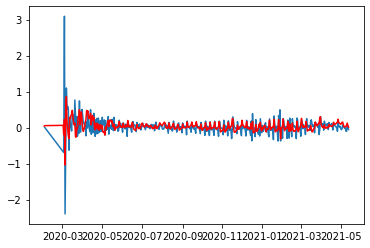

In [27]:
decomposition = seasonal_decompose(df_log,freq=30)
model = ARIMA(df_log, order = (2,1,2))
results = model.fit(disp = -1)
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color = 'red')

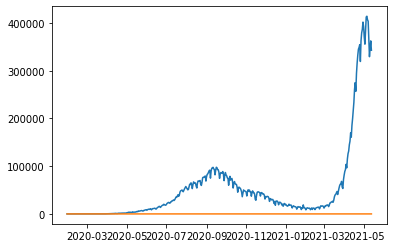

In [ ]:
pridiction_ARIMA_diff = pd.Series(results.fittedvalues,copy = True)
pridiction_ARIMA_diff_cumsum = pridiction_ARIMA_diff.cumsum()
pridiction_ARIMA_log = pd.Series(df_log['Daily Confirmed'].iloc[0],index = df_log.index)
pridiction_ARIMA_log = pridiction_ARIMA_log.add(pridiction_ARIMA_diff_cumsum, fill_value = 0)
pridiction_ARIMA = np.exp(pridiction_ARIMA_log)
plt.plot(df)
plt.plot(pridiction_ARIMA) 

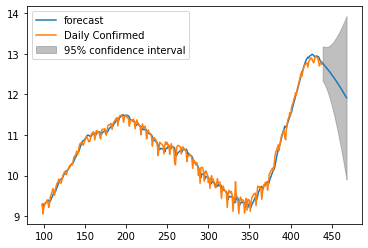

In [ ]:
pred = results.plot_predict(100,470)